In [36]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

np.random.seed(1)
torch.manual_seed(1)

In [37]:
# Define Force Field

def f_orig(x):
    return torch.transpose(torch.stack([x[:,1], torch.zeros_like(x[:,0])]),0,1)

def x2xp(x):
    y = torch.ones_like(x)
    y[:,0] = np.e**(0.5*x[:,0]) + np.e**(0.5*x[:,1])
    y[:,1] = np.e**(0.5*x[:,0]) - np.e**(0.5*x[:,1])
    return y

def f(x):
    return torch.transpose(torch.stack([0.5*(x[:,0]+x[:,1])*torch.log(0.5*(x[:,0]-x[:,1])), 0.5*(x[:,0]+x[:,1])*torch.log(0.5*(x[:,0]-x[:,1]))]),0,1)


x = np.linspace(-1,1,num=21)
y = np.linspace(-1,1,num=21)
xx,yy= np.meshgrid(x,y)

input_grid = torch.tensor(np.transpose(np.array([xx.reshape(-1), yy.reshape(-1)])), dtype=torch.float, requires_grad = True)
input_ = x2xp(input_grid)
input_d = input_.shape[1]

# Define Transformer

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

class T(nn.Module):
    def __init__(self,w=200):
        super(T, self).__init__()
        self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,input_d)
    
    def forward(self, x, eps=0.1):
        bs = x.shape[0]
        #f = nn.Tanh()
        f = nn.SiLU()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return x + eps*self.x3
    
    #def forward(self, x, eps=0.0):
    #    return self.l0(x)
    
    def transform_f(self, x):
        jac_ts = batch_jacobian(self.forward, x, create_graph=True)
        return torch.matmul(jac_ts, torch.unsqueeze(f(x), dim=2))

In [38]:
# Loss library

# Lie group: for SO(2), g_J = [[0,1],[-1,0]]

def Jp_(f,t,inputs):
    input_d = input_.shape[1]
    jac_f = batch_jacobian(f,inputs,create_graph=True)
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    jac_inv_ts = torch.inverse(jac_ts)

    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)

    # calculate J'
    Jp1 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*hess_t.permute(0,2,1,3).unsqueeze(dim=2)*f(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3)
    Jp2 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*jac_ts.unsqueeze(dim=2).unsqueeze(dim=3)*jac_f.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=2)
    Jp = Jp1 + Jp2
    Jp = torch.sum(torch.sum(Jp,dim=4),dim=3)
    return Jp

def hess(t, inputs):
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    
    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)
    
    return hess_t
    

def off_diag(M,n_part=[2,2]):
    bs = M.shape[0]
    input_d = M.shape[1]
    assert input_d == np.sum(n_part)
    start = 0
    end = n_part[0]
    diag_loss = 0
    for i in range(len(n_part)):
        diag_loss = diag_loss + torch.sum(M[:,start:end, start:end]**2)
        start = end
        end = end + n_part[i]
    return (torch.sum(M**2) - diag_loss)/(batch_size*input_d**2)


def lie_loss(f,t,inputs):
    
    bs = inputs.shape[0]
    # for SO(2)
    g_J = torch.tensor([[0,1],[-1,0]], dtype=torch.float, requires_grad=True)
    Jp = Jp_(f,t,inputs)
    fp = t.transform_f(inputs)
    inputsp = torch.unsqueeze(t(inputs), dim=2)
    
    g_J = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=1) * torch.unsqueeze(g_J, dim=0)
    pde = torch.matmul(torch.matmul(Jp.permute(0,1,2),g_J),inputsp) - torch.matmul(g_J, fp)
    r_mse = torch.mean(inputsp**2)
    loss = torch.mean(pde**2)
    return loss/r_mse

def translation_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)[:,0]
    loss = torch.mean(Jp**2)
    return loss

def modularity_loss(f,t,inputs,n_part=[2,2]):
    Jp = Jp_(f,t,inputs)
    loss = off_diag(Jp,n_part=n_part)
    return loss

def hamiltonicity_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)
    input_d = inputs.shape[1]
    assert input_d % 2 ==0
    M = torch.zeros(input_d, input_d)
    half_d = int(input_d/2)
    M[:half_d, half_d:] = torch.eye(half_d)
    M[half_d:, :half_d] = -torch.eye(half_d)
    M = torch.tensor(M, dtype=torch.float, requires_grad=True)
    JMMJ = torch.matmul(Jp.permute(0,2,1), M) + torch.matmul(M, Jp)
    loss = torch.mean(JMMJ**2)
    return loss
    

In [39]:
from celluloid import Camera
fig = plt.figure(figsize=(15,5))
camera = Camera(fig)


# Training a transformer to minimize PDE losses


np.random.seed(0)
torch.manual_seed(0)

t = T(w=400)
epochs = 5000
switch_epoch = 2500
lr_decay_epoch = 500

n_train = input_.shape[0]
batch_size = 128

lr = 1e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 50


losses_tran = [] # translational
losses_ham = [] # hamiltonicity
losses_jac = []

for epoch in range(epochs):

    t.train()
    optimizer.zero_grad()
    
    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]
    
    if epoch == switch_epoch:
        for opt_param in optimizer.param_groups:
            lr = 1e-3
            opt_param['lr'] = lr
    
    if (epoch+1) % lr_decay_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr
    
    if epoch < switch_epoch:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_tran = float("nan")
        losses_ham.append(loss_ham.detach().numpy())
        losses_tran.append(loss_tran)
        loss = loss_ham
    else:
        loss_tran = translation_loss(f,t,inputs)
        loss_ham = hamiltonicity_loss(f,t,inputs)
        losses_tran.append(loss_tran.detach().numpy())
        losses_ham.append(loss_ham.detach().numpy())
        loss = loss_tran + loss_ham
        
        
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch%log == 0:
        print('Epoch:  %d | Loss_tran: %.4f | Loss_ham: %.4f ' %(epoch, loss_tran, loss_ham))
        
    

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  0 | Loss_tran: nan | Loss_ham: 0.0425 
Epoch:  50 | Loss_tran: nan | Loss_ham: 0.0004 
Epoch:  100 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  150 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  200 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  250 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  300 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  350 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  400 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  450 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  500 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  550 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  600 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  650 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  700 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  750 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  800 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  850 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  900 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  950 | Loss_tran: nan | Loss_ham: 0.0000 
Epoch:  1000 | Loss_tra

<Figure size 1080x360 with 0 Axes>

In [40]:
np.save('./results/1dum_loss.npy', [losses_ham, losses_tran])

In [41]:
import numpy as np
losses = np.load('./results/1dum_loss.npy')
loss_ham = losses[0]
loss_tran = losses[1]

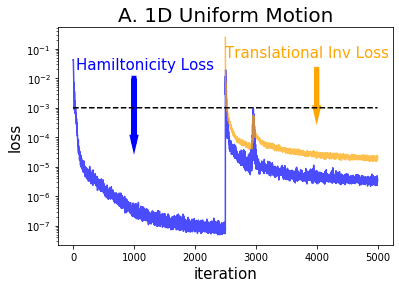

In [49]:
plt.plot(np.arange(epochs), losses_ham, color="blue",alpha=0.7)
plt.plot(np.arange(epochs), losses_tran, color="orange",alpha=0.7)

plt.xlabel("iteration",fontsize=15)
plt.ylabel("loss",fontsize=15)
plt.title("A. 1D Uniform Motion",fontsize=20)
plt.yscale('log')
plt.plot(np.arange(epochs), np.ones(epochs,)*1e-3, ls="--", color="black")
plt.arrow(1000,0.01,0,-0.0099,head_width=50,head_length=0.00004,linewidth=5, color="blue")
plt.text(50,0.02,"Hamiltonicity Loss",fontsize=15,color="blue")
plt.arrow(4000,0.02,0,-0.019,head_width=50,head_length=0.0004,linewidth=5, color="orange")
plt.text(2500,0.05,"Translational Inv Loss",fontsize=15,color="orange")
#plt.savefig('./1dum.png')
plt.savefig('./figures/1dUM.pdf', bbox_inches="tight")

In [6]:
loss_save = np.array([losses_ham, losses_tran])

In [7]:
np.save('./results/1dum_loss.npy', loss_save)

Text(0.33499999999999996, 0.0006, '$\\lambda=0.001$')

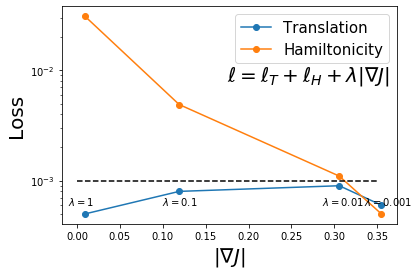

In [45]:
lambs = [0.001,0.01,0.1,1]
loss_t = [0.0006,0.0009,0.0008,0.0005]
loss_h = [0.0005,0.0011,0.0049,0.0309]
loss_jac = [0.3550,0.3059,0.1191,0.0092]
plt.plot(loss_jac, loss_t, marker="o")
plt.plot(loss_jac, loss_h, marker="o")
plt.yscale('log')
plt.xlabel(r"$|\nabla J|$",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.plot([0.0,0.35],[0.001,0.001],ls="--",color="black")
plt.legend(["Translation", "Hamiltonicity"],fontsize=15)
plt.text(0.175,0.008,r"$\ell=\ell_T+\ell_H+\lambda|\nabla J|$",fontsize=20)
plt.text(0.0092-0.02,0.0006,r"$\lambda=1$",fontsize=10)
plt.text(0.1191-0.02,0.0006,r"$\lambda=0.1$",fontsize=10)
plt.text(0.3059-0.02,0.0006,r"$\lambda=0.01$",fontsize=10)
plt.text(0.3550-0.02,0.0006,r"$\lambda=0.001$",fontsize=10)